# Train MLP Baseline (toy example and hyperparameter tuning)

This notebook trains the `MLPBaseline` model from `model_classes/mlp_baseline.py` with a simple forward/backward loop and a small hyperparameter grid search.

Notes:
- For demonstration this uses a synthetic dataset (random features + labels). Replace the data-loading cell with your real dataset / `DataLoader` from `data_loaders.py` when ready.
- Training loop is minimal: forward, compute loss, backward, optimizer step.
- Hyperparameter tuning is a simple grid search over a few combos; it's not parallelized.

In [1]:
import os
import sys

# Assuming you start the notebook from the training_scripts/ directory
PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

print("Project root in sys.path:", PROJECT_ROOT)


Project root in sys.path: /home/quiet98k/Code/Fall25/hand-gestures-classifier


In [2]:
# Basic imports and helper utilities
import os
from itertools import product
from typing import Tuple, Dict, Any

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Import model factory and dataset from the repo
from model_classes.mlp_baseline import create_mlp_baseline
from data_loaders import LandmarksDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


In [3]:
# Use the real LandmarksDataset from the repository
# We flatten landmarks for the MLP (shape: N_landmarks * 2)
torch.manual_seed(42)

# Create train/val dataset instances (assumes data/annotations/{train,val} exist)
annotations_root = "../data/annotations"
train_ds = LandmarksDataset(annotations_root=annotations_root, split='train', flatten=True)
val_ds = LandmarksDataset(annotations_root=annotations_root, split='val', flatten=True)

# Infer input_dim and num_classes from dataset (keeps things consistent)
first = train_ds[0]['landmarks']
if isinstance(first, torch.Tensor):
    input_dim = int(first.numel())
else:
    # Fallback: assume 42 features if something unusual happens
    input_dim = 42
num_classes = train_ds.num_classes

print('Dataset sizes: train=', len(train_ds), 'val=', len(val_ds))
print('Input dim (flattened landmarks):', input_dim, 'Num classes:', num_classes)

# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, drop_last=False)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, drop_last=False)

# Quick smoke test: retrieve one batch and print basic shapes
try:
    batch = next(iter(train_loader))
    print('Successfully retrieved a batch from train_loader')
except Exception as e:
    print('Error when iterating train_loader:', repr(e))
    raise

# Extract landmarks and labels from batch
if isinstance(batch, dict):
    xb = batch['landmarks']
    yb = batch['label']
else:
    xb, yb = batch

print('Batch shapes:', getattr(xb, 'shape', None), getattr(yb, 'shape', None))

Dataset sizes: train= 408237 val= 53392
Input dim (flattened landmarks): 42 Num classes: 18
Successfully retrieved a batch from train_loader
Batch shapes: torch.Size([64, 42]) torch.Size([64])


In [4]:
# Training and evaluation helpers
def train_epoch(model: nn.Module, loader: DataLoader, optimizer, criterion, log_interval: int = 100) -> Dict[str, float]:
    """Run one training epoch and optionally print batch-level summaries.
    Prints periodic batch summaries showing batch index, remaining batches, avg loss and acc for the window.
    """
    model.train()
    total_loss = 0.0
    total_correct = 0
    total = 0
    window_loss = 0.0
    window_correct = 0
    window_samples = 0
    for batch_idx, batch in enumerate(loader, start=1):
        # Support both dict-style batches (from our Dataset) and tuple batches
        if isinstance(batch, dict):
            xb = batch['landmarks']
            yb = batch['label']
        else:
            xb, yb = batch

        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        bsz = xb.size(0)
        total_loss += loss.item() * bsz
        preds = logits.argmax(dim=1)
        correct = (preds == yb).sum().item()
        total_correct += correct
        total += bsz

        # update window
        window_loss += loss.item() * bsz
        window_correct += correct
        window_samples += bsz

        # periodic print every `log_interval` batches
        if log_interval and (batch_idx % log_interval == 0):
            avg_loss = window_loss / window_samples if window_samples else 0.0
            avg_acc = window_correct / window_samples if window_samples else 0.0
            total_batches = len(loader) if hasattr(loader, '__len__') else '??'
            print(f"Batch {batch_idx}/{total_batches} | avg_loss={avg_loss:.4f} avg_acc={avg_acc:.4f}")
            # reset window counters
            window_loss = 0.0
            window_correct = 0
            window_samples = 0

    return {
        'loss': total_loss / total,
        'acc': total_correct / total,
    }

def evaluate(model: nn.Module, loader: DataLoader, criterion) -> Dict[str, float]:
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total = 0
    with torch.no_grad():
        for batch in loader:
            if isinstance(batch, dict):
                xb = batch['landmarks']
                yb = batch['label']
            else:
                xb, yb = batch

            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            total_loss += loss.item() * xb.size(0)
            preds = logits.argmax(dim=1)
            total_correct += (preds == yb).sum().item()
            total += xb.size(0)

    return {
        'loss': total_loss / total,
        'acc': total_correct / total,
    }

In [5]:
# Simple hyperparameter grid search (small grid for demo)
results = []
save_dir = os.path.join('..', os.getcwd(), 'training_outputs')
os.makedirs(save_dir, exist_ok=True)

param_grid = {
    'lr': [3e-4, 1e-3],

    'hidden_dims': [
        (128, 64),
        (256, 128),
    ],

    'dropout': [0.1, 0.3],

    'batchnorm': [False, True],

    'batch_size': [128, 256],

    'max_epochs': [8, 12],
}

# Loss (kept separate for clarity)
criterion = nn.CrossEntropyLoss()

# iterate grid
# How often to print batch-level progress inside an epoch (set 0 to disable):
log_interval = 500
for lr, hidden_dims, dropout, batchnorm, batch_size, max_epochs in product(
    param_grid['lr'], param_grid['hidden_dims'], param_grid['dropout'], param_grid['batchnorm'],
    param_grid['batch_size'], param_grid['max_epochs']
):
    print('Running config:', {'lr': lr, 'hidden_dims': hidden_dims, 'dropout': dropout, 'batchnorm': batchnorm, 'batch_size': batch_size, 'max_epochs': max_epochs})

    # build model and loaders
    model = create_mlp_baseline(input_dim=input_dim, num_classes=num_classes, hidden_dims=hidden_dims, dropout=dropout, activation='relu', batchnorm=batchnorm)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # create DataLoaders directly (no helper)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, drop_last=False)

    best_val_acc = 0.0
    best_state: dict[str, Any] | None = None

    # history for this config (per-epoch)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(1, max_epochs + 1):
        prefix = f"Config lr={lr} bs={batch_size} | Epoch {epoch}/{max_epochs}"
        tr = train_epoch(model, train_loader, optimizer, criterion, log_interval=log_interval)
        # run validation inside epoch (after training pass)
        va = evaluate(model, val_loader, criterion)

        # record history
        history['train_loss'].append(tr['loss'])
        history['train_acc'].append(tr['acc'])
        history['val_loss'].append(va['loss'])
        history['val_acc'].append(va['acc'])

        # more detailed per-epoch message
        print(f"Epoch {epoch}/{max_epochs} | train_loss={tr['loss']:.4f} train_acc={tr['acc']:.4f} | val_loss={va['loss']:.4f} val_acc={va['acc']:.4f}")

        # save best model for this config
        if va['acc'] > best_val_acc:
            best_val_acc = va['acc']
            best_state = {
                'model_state': model.state_dict(),
                'optimizer_state': optimizer.state_dict(),
                'epoch': epoch,
            }

    # persist best for this config
    config_name = f"mlp_lr{lr}_hd{hidden_dims[0]}-{hidden_dims[1]}_do{int(dropout*100)}_bn{int(batchnorm)}_bs{batch_size}_ep{max_epochs}"
    out_path = os.path.join(save_dir, config_name + '.pth')
    if best_state is not None:
        torch.save({'config': {'lr': lr, 'hidden_dims': hidden_dims, 'dropout': dropout, 'batchnorm': batchnorm, 'batch_size': batch_size, 'max_epochs': max_epochs}, 'best_val_acc': best_val_acc, 'state': best_state}, out_path)

    results.append({'config': {'lr': lr, 'hidden_dims': hidden_dims, 'dropout': dropout, 'batchnorm': batchnorm, 'batch_size': batch_size, 'max_epochs': max_epochs}, 'best_val_acc': best_val_acc, 'path': out_path, 'history': history})

# summarize results
results_sorted = sorted(results, key=lambda r: r['best_val_acc'], reverse=True)
print('Top results:')
for r in results_sorted[:5]:
    print(r['best_val_acc'], r['config'], r['path'])

Running config: {'lr': 0.0003, 'hidden_dims': (128, 64), 'dropout': 0.1, 'batchnorm': False, 'batch_size': 128, 'max_epochs': 8}
Batch 500/3190 | avg_loss=1.9988 avg_acc=0.3665
Batch 500/3190 | avg_loss=1.9988 avg_acc=0.3665
Batch 1000/3190 | avg_loss=1.1221 avg_acc=0.5476
Batch 1000/3190 | avg_loss=1.1221 avg_acc=0.5476
Batch 1500/3190 | avg_loss=0.9480 avg_acc=0.6249
Batch 1500/3190 | avg_loss=0.9480 avg_acc=0.6249
Batch 2000/3190 | avg_loss=0.7745 avg_acc=0.7134
Batch 2000/3190 | avg_loss=0.7745 avg_acc=0.7134
Batch 2500/3190 | avg_loss=0.6105 avg_acc=0.7880
Batch 2500/3190 | avg_loss=0.6105 avg_acc=0.7880
Batch 3000/3190 | avg_loss=0.4943 avg_acc=0.8326
Batch 3000/3190 | avg_loss=0.4943 avg_acc=0.8326
Epoch 1/8 | train_loss=0.9588 train_acc=0.6578 | val_loss=0.3466 val_acc=0.9184
Epoch 1/8 | train_loss=0.9588 train_acc=0.6578 | val_loss=0.3466 val_acc=0.9184
Batch 500/3190 | avg_loss=0.4028 avg_acc=0.8762
Batch 500/3190 | avg_loss=0.4028 avg_acc=0.8762
Batch 1000/3190 | avg_loss=0.

In [6]:
# Load best model and do a quick inference check
best = results_sorted[0]
print('Best config:', best['config'], 'val_acc=', best['best_val_acc'])
ckpt = torch.load(best['path'], map_location=device)
cfg = ckpt['config']
model = create_mlp_baseline(input_dim=input_dim, num_classes=num_classes, hidden_dims=tuple(cfg['hidden_dims']), dropout=cfg['dropout'], activation='relu', batchnorm=cfg['batchnorm'])
model.load_state_dict(ckpt['state']['model_state'])
model = model.to(device).eval()

# run inference on a small batch
batch = next(iter(val_loader))
if isinstance(batch, dict):
    xb = batch['landmarks']
    yb = batch['label']
else:
    xb, yb = batch
with torch.no_grad():
    logits = model(xb.to(device))
    preds = logits.argmax(dim=1).cpu()

print('Sample preds:', preds[:10].tolist())
print('Sample labels:', yb[:10].tolist())

Best config: {'lr': 0.001, 'hidden_dims': (128, 64), 'dropout': 0.1, 'batchnorm': True, 'batch_size': 128, 'max_epochs': 12} val_acc= 0.9926018879232844
Sample preds: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Sample labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


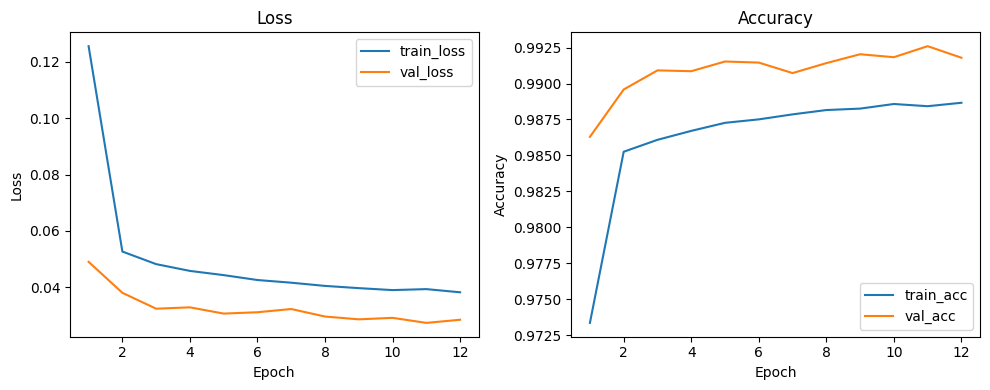

In [8]:
# Plot training/validation history for the best config
import matplotlib.pyplot as plt
best = results_sorted[0]
hist = best.get('history')
if hist is None:
    print('No history available for best config')
else:
    epochs = list(range(1, len(hist['train_loss']) + 1))
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, hist['train_loss'], label='train_loss')
    plt.plot(epochs, hist['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, hist['train_acc'], label='train_acc')
    plt.plot(epochs, hist['val_acc'], label='val_acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()